In [1]:
"""
2022/05/13
image style transformer
"""
import matplotlib.pyplot as plt # plt 用于显示图片
import matplotlib.image as mpimg # mpimg 用于读取图片
from matplotlib.pyplot import MultipleLocator
from PIL import Image
import numpy as nn
import torch
import torch.nn as nn
import torchvision.models as models
import numpy as np
import cv2
import torch.nn.functional as F
from torch.autograd import Variable


In [2]:
class transformer(nn.Module) :
  def __init__(self,subnet) :
    super(transformer,self).__init__()
    self.net = subnet
    for name,layer in self.net.named_children() :
      if isinstance(layer,nn.MaxPool2d) :
        self.net[int(name)] = nn.AvgPool2d(kernel_size = 2, stride = 2)


  def get_gram_matrix(self,style) :
    gram_matrix = []
    for i in range(len(style)) :
      c,h,w = style[i].size()
      temp = style[i].view(c,h*w)
      gram_i = torch.mm(temp,temp.t()).div(c*h*w)
      gram_matrix.append(gram_i)

    return gram_matrix

  
  def forward(self,x,content_list,style_list) :
    content = []
    style  = []
    for name,layer in self.net.named_children() :
      x = layer(x)
      if int(name) in content_list :
        content.append(x)
      if int(name) in style_list :
        style.append(x)

    style_matrix = self.get_gram_matrix(style)

    return content,style_matrix



In [3]:
def train(x, net, parameter_list, content, style):
    epoches = parameter_list["epoches"]
    k = parameter_list["k"]
    lrate = parameter_list["lr"]
    device = parameter_list["device"]
    content_list = parameter_list["content_list"]
    style_list = parameter_list["style_list"]
    path = parameter_list["path"]
    x.requires_grad = True
    x.to(device)
    net.to(device)
    net.eval()
    optimizer = torch.optim.Adam([x], lr=lrate, betas=(0.9, 0.999), eps=1e-8)
    content_loss_list = []
    style_loss_list = []
    loss_list = []
    x_list = []
    for epoch in range(epoches):
        net.eval()
        x = x.to(device)
        x.requires_grad = True
        optimizer.zero_grad()
        content_loss = torch.tensor([0]).cuda().float()
        style_loss = torch.tensor([0]).cuda().float()
        loss = torch.tensor([0]).cuda().float()

        x_content, x_style = net(x, content_list, style_list)

        for i in range(len(x_content)):
            content_loss += F.mse_loss(x_content[i], content[i])
        for i in range(len(x_style)):
            style_loss += F.mse_loss(x_style[i], style[i])
        tv_loss = (
            torch.sum(torch.abs(x[:, :, :-1] - x[:, :, 1:]))
            + torch.sum(torch.abs(x[:, :-1, :] - x[:, 1:, :]))
        ) / (3 * 512 * 512)
        loss = 1e-2 * content_loss + 1e7 * style_loss + 1e-3 * tv_loss
        content_loss_list.append(content_loss.item())
        style_loss_list.append(style_loss.item())
        loss_list.append(loss.item())
        x_list.append(epoch)
        loss.backward()
        optimizer.step()
        if epoch % 200 == 0:
            img = x.clone()
            img = torch.clamp(img, 0, 1) * 255
            img = img.permute(1, 2, 0)
            img = img.data.cpu().numpy().astype(int)

            plt.imshow(img[:, :, [2, 1, 0]])  # 显示图片
            plt.axis("off")  # 不显示坐标轴
            plt.show()

            print(
                "epoch ",
                epoch,
                "\n",
                content_loss.item(),
                "\n",
                style_loss.item(),
                "\n",
                loss.item(),
                "\n----------------------",
            )

    l1 = plt.plot(x_list, content_loss_list, "r--", label="content_loss")
    l2 = plt.plot(x_list, style_loss_list, "g--", label="style_loss")
    l3 = plt.plot(x_list, loss_list, "b--", label="loss")
    plt.title("loss Conditions")
    plt.xlabel("epoch")
    plt.ylabel("cost")
    # plt.legend()
    plt.show()

    return 0

device =  cuda


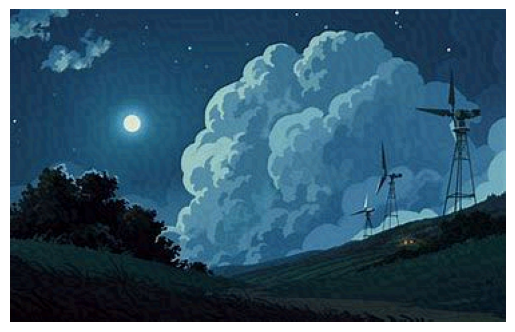

epoch  0 
 0.0 
 1.0509594403629308e-06 
 10.50960636138916 
----------------------


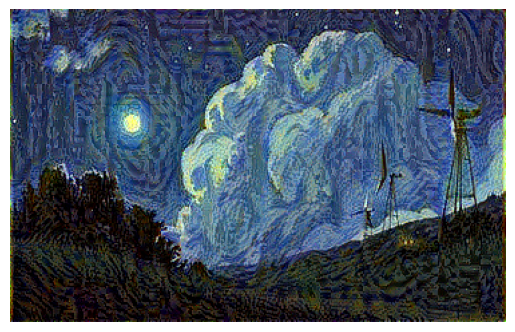

epoch  200 
 0.08173805475234985 
 1.7132271157294099e-09 
 0.018007388338446617 
----------------------


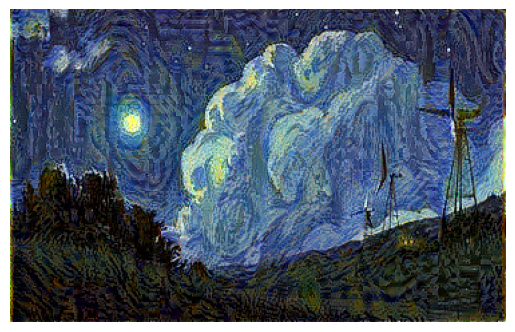

epoch  400 
 0.08385951817035675 
 9.58808255013821e-10 
 0.010485432110726833 
----------------------


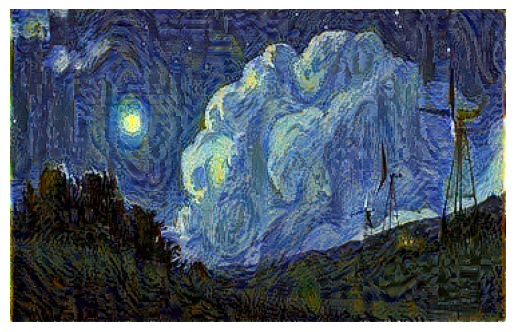

epoch  600 
 0.08412172645330429 
 6.952577957797246e-10 
 0.007853168062865734 
----------------------


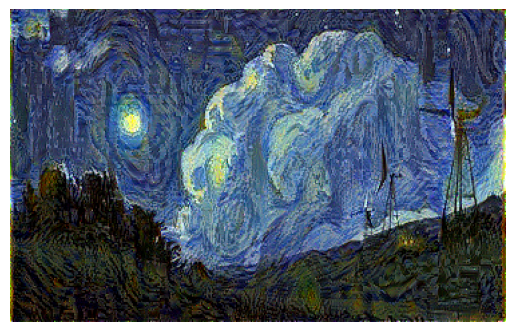

epoch  800 
 0.0841476172208786 
 5.561071603210621e-10 
 0.006462446413934231 
----------------------


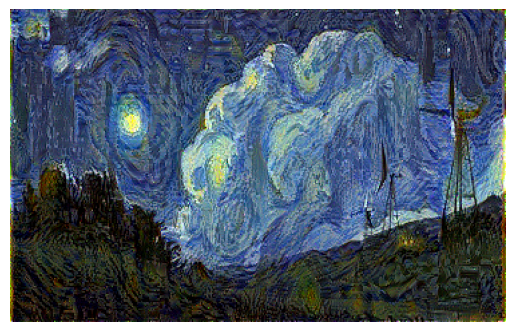

epoch  1000 
 0.08406686037778854 
 4.696981137364276e-10 
 0.005598024465143681 
----------------------


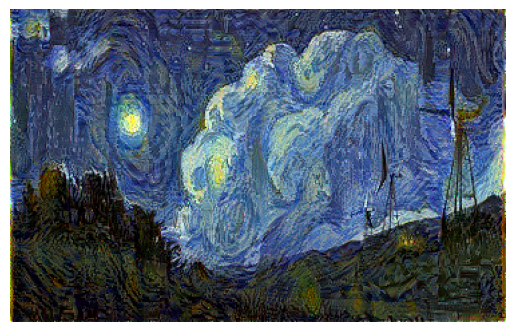

epoch  1200 
 0.08398931473493576 
 4.10530498484718e-10 
 0.005005997605621815 
----------------------


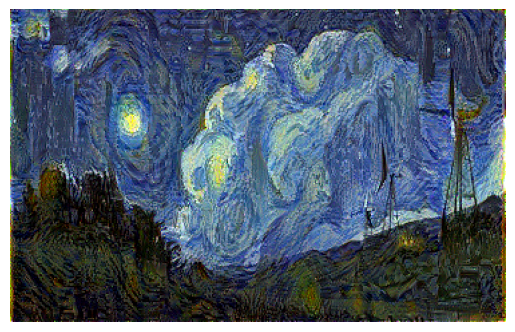

epoch  1400 
 0.08397497236728668 
 3.676953186371179e-10 
 0.00457788584753871 
----------------------


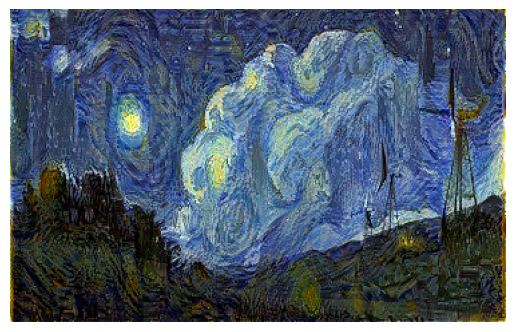

epoch  1600 
 0.08393748849630356 
 3.352250421695402e-10 
 0.004253136459738016 
----------------------


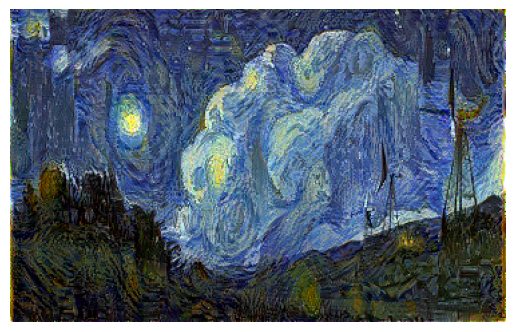

epoch  1800 
 0.08391603827476501 
 3.1000635392075537e-10 
 0.00400102324783802 
----------------------


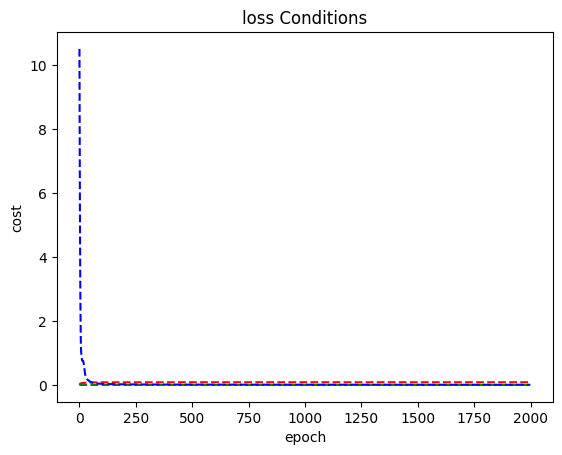

0

In [5]:
def main() :

  content_path = "pic\OIP.jpg"
  style_path = "pic\starry.jpg"
  path = "/kaggle/working/"
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
  print("device = ",device)

  content_img =  (cv2.imread(content_path))
  style_img   = cv2.resize( (cv2.imread(style_path)),(content_img.shape[0],content_img.shape[1]) )
  
  content_tensor = torch.from_numpy(content_img).to(device).float() / 255
  content_tensor = content_tensor.permute(2,0,1)
                                         
  style_tensor = torch.from_numpy(style_img).to(device).float() / 255
  style_tensor = style_tensor.permute(2,0,1)
  x_tensor =  content_tensor.clone()
  x_tensor=Variable(x_tensor,requires_grad=True)
  content_list = [25]
  style_list  = [0, 5, 10, 19, 28]
  net = models.vgg19(pretrained=True).features
  net.to(device)
  for params in net.parameters():
    params.requires_grad = False
  net.eval()
  
  
  net1 = transformer(net)
  content,noused = net1(content_tensor,content_list,style_list)
  net2 = transformer(net)
  noused,style = net2(style_tensor,content_list,style_list)
  
  

  net3 = transformer(net)
  parameter_list = {
      "device" : device,
      "k" : 0.0001,
      "epoches" : 2000,
      "style_list" : style_list,
      "content_list" : content_list,
      "lr" : 1e-2,
      "path" : path

  }
  result = train(x_tensor,net3,parameter_list,content,style)
  return 0

main()